In [1]:
import sys
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython']

In [2]:
import tensorflow as tf
import numpy as np
import scipy.io
from skimage.transform import resize


tf.enable_eager_execution()

execfile("definitions.py")
execfile("genSIEdef_angles.py")

RESTORE = True
train_batch_size = 10
num_features = 512

with tf.device('/gpu:0'):
    RT = RayTracer()
    kap_gen = SRC_KAPPA_Generator(train_batch_size=train_batch_size,kap_side_length=20.48,num_src_side=num_features,num_kappa_side=num_features)

    #VAE_obj = VAE()
    #VAE_checkpoint_path = "checkpoints/model_VAE"
    #VAE_obj.load_weights(VAE_checkpoint_path)

    optimizer = tf.train.AdamOptimizer(1.0e-4)
    checkpoint_path = "checkpoints/model_Unet_test"
    save_checkpoint_path = "checkpoints/model_Unet_test"
    if (RESTORE==True):
        RT.load_weights(checkpoint_path)

/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl

In [20]:
optimizer = tf.train.AdamOptimizer(5.0e-6)

In [6]:
x_alpha = np.zeros((train_batch_size,num_features, num_features,1))
y_alpha = np.zeros((train_batch_size,num_features, num_features,1))
kappa = np.zeros((train_batch_size,num_features, num_features,1))

xim, yim = np.meshgrid( np.linspace(-10.24,10.24,512)*  np.pi / 180 / 3600, np.linspace(-10.24,10.24,512) * np.pi / 180 / 3600)

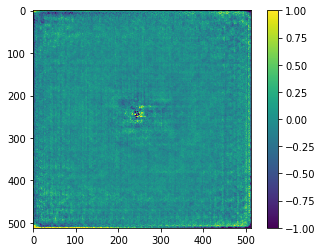

(0, 1340, 0.018916165)
(0, 1341, 0.0099576805)
(0, 1342, 0.013321655)
(0, 1343, 0.012875957)
(0, 1344, 0.010099938)


In [ ]:
with tf.device('/gpu:0'):
    for epoch in range(1):
        for train_iter in range(40000):
            
            # To train on analytical SIEs
            for i in range(train_batch_size):
                #np.random.seed(seed=136)
                xlens = np.random.uniform(low=-1.0, high=1.)
                ylens = np.random.uniform(low=-1.0, high=1.)
                elp = np.random.uniform(low=0.01, high=0.6)
                phi = np.random.uniform(low=0.0, high=2.*np.pi)
                Rein = np.random.uniform(low=0.5, high = 7.)
                x_alpha[i,:,:,0] , y_alpha[i,:,:,0]  = raytrace(xim,yim,[Rein, elp , phi*180/np.pi  , xlens , ylens])
                
                kappa[i,:,:,0]  = kap_gen.Kappa_fun(xlens, ylens, elp, phi, Rein)
            x_alpha = x_alpha*180/(np.pi)*3600
            y_alpha = y_alpha*180/(np.pi)*3600
            x_a_labels = tf.cast( x_alpha, datatype)
            y_a_labels = tf.cast( y_alpha, datatype)
            
            tf_kappa = tf.cast( kappa , datatype)
            

            with tf.GradientTape() as tape:
                tape.watch(RT.variables)
                cost_value , ALFA = RT.cost_function(tf_kappa , x_a_labels , y_a_labels)
            weight_grads = tape.gradient(cost_value, [RT.variables] )

            clipped_grads = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[0]]
            optimizer.apply_gradients(zip(clipped_grads, RT.variables), global_step=tf.train.get_or_create_global_step())

            print( epoch, train_iter , cost_value.numpy() )
            
            if (((train_iter+1)%10)==0):
                print( "saving weights." )
                RT.save_weights(save_checkpoint_path)
                pl.clf()
                pl.imshow(ALFA[0,:,:,0]-x_a_labels[0,:,:,0],vmin=-1.,vmax=1.)
                pl.colorbar()
                display.clear_output(wait=True)
                display.display(pl.gcf())

            

In [14]:
(ALFA[0,:,:,0].numpy()-x_a_labels[0,:,:,0])

(512, 512)

In [5]:
np_kappa = np.load('np_kappa.npy')

In [9]:
np.max(np_kappa)

76.05417

In [7]:
cost_value , ALFA = RT.cost_function(np_kappa , x_a_labels , y_a_labels)

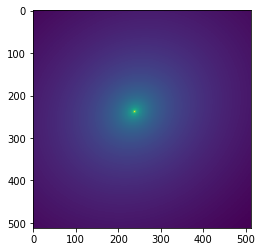

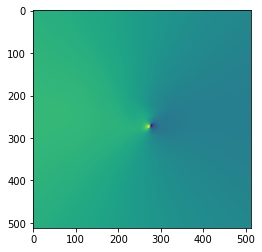

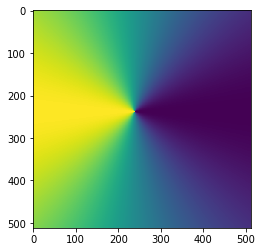

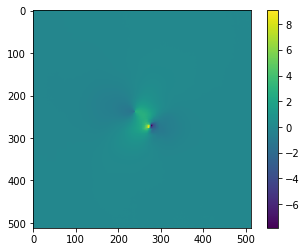

In [8]:
plt.figure()
plt.imshow(np.log10(tf_kappa[0,:,:,0]))
plt.figure()
plt.imshow(ALFA[0,:,:,0])
plt.figure()
plt.imshow(x_a_labels[0,:,:,0])
plt.figure()
plt.imshow(ALFA[0,:,:,0]-x_a_labels[0,:,:,0])
plt.colorbar()